## Riksarkivet SBL  - Wikidata ett försök att synka dom
version 0.46 this [notebook](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)

WD egenskap [Property:P3217](https://www.wikidata.org/wiki/Property:P3217) 
* SBL personartiklar som saknar [sv:Wikipedia artikel](https://w.wiki/c5f) < 150
* [SBL vs SKBL female articles](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  

#### Andra källor vi synkar
* [Litteraturbanken](https://github.com/salgo60/open-data-examples/blob/master/Litteraturbanken%20Author.ipynb)
* [Nobelprize.org](https://github.com/salgo60/open-data-examples/blob/master/Nobel%20API.ipynb)
* [SBL](https://github.com/salgo60/open-data-examples/blob/master/SBL.ipynb)
* [SKBL](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)  

### SBL
SBL har idag
* personartiklar
* släktartiklar
  * en person i en släktartikel kan ha en sida som bara pekar till släktartikeln (med text ej alltid länk)

Det saknas idag från Riksarkivet ett API så nedanstående är ett försök att webscrapa deras data och sedan försöka hitta en struktur. 

Målsättningen är att ha personerna som har en SBL personartikel representerade i Wikidata. Kul vore att även ha släktartiklarna kopplade till Wikidata... är inte säkert hur bra strukturen är för släkter/ätter/familjer i WD och sedan behövs det matchas en hel del. En person kan även omnämnas i en släktartikel och bör då i Wikidata ha "beskriven av källa" kopplad till dessa artiklar (exempel Gunnar Mossing [Q5994570#P1343](https://www.wikidata.org/wiki/Q5994570#P1343) som finns i artikel SBL ["Morssing, släkt"](https://sok.riksarkivet.se/sbl/Presentation.aspx?id=9512)) vilket är ett mycket stort jobb om Riksarkivet inte går över till att leverera [länkade data](https://sv.wikipedia.org/wiki/L%C3%A4nkade_data)...     

**Mina gissningar** 
1. sida med född/död är en person
2. sida med titel släkt är en släktartikel
3. sida med född/död men för kort kan vara en referens till en släktartikel
4. släkt artikel kan ha "[ätt](https://sok.riksarkivet.se/sbl/Search.aspx?t=0)" i titeln men det kan visst även person artiklar ha
5. ....

### jmf SKBL med SBL 
med ett mera komplett Wikidata kan vi nu jämföra [Svenskt Kvinnobiografiskt lexikon - SKBL](https://www.skbl.se/sv/om-skbl) med [Riksarkivet](https://sok.riksarkivet.se/sbl/OmSBL.aspx) då det gäller urval av kvinnor, antal kvinnor, hur dom levererar, API vs. inte API, skillnaden att ha enbart svenska artiklar som SBL med att även ha [engelska artiklar som SKBL](https://www.skbl.se/en/about-skbl) 

* [Notebook](https://github.com/salgo60/open-data-examples/blob/master/Svenskt%20Kvinnobiografiskt%20lexikon%20part%203.ipynb)

# Webscrape 
1. vi gissar id min 4000 och max 40000


In [1]:
from datetime import datetime
now = datetime.now()
print("Last run: ", now)

Last run:  2020-09-17 06:49:48.910460


In [2]:
import urllib3, json
import pandas as pd   
from bs4 import BeautifulSoup
import sys
import pprint
http = urllib3.PoolManager()

from tqdm.notebook import trange  
listNewItems =[]

for SBLnr in trange(4000,40000): #gissar min 4000 max 40000
    url = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(SBLnr)
    r = http.request('GET', url) 
    if len(r.data) > 11020:
        new_item = dict()
        #print(SBLnr)
        new_item['SBLnr'] = SBLnr
        new_item['SBLlength'] = len(r.data)
        soup = BeautifulSoup(r.data, "html.parser")  
        
        try:
            titel = soup.findAll("span", {"id": "ctl00_MainContent_lblTitle"})[0].get_text()
            new_item['titel'] = titel
            #print ("\t",titel)
        except:
            pass
        try:
            Fodd = soup.findAll("span", {"id": "ctl00_MainContent_lblFodelse"})[0].get_text()
            #print ("\t",Fodd)
            new_item['Fodd'] = Fodd
        except:
            pass
        try:
            Dod = soup.findAll("span", {"id": "ctl00_MainContent_lblDod"})[0].get_text()
            #print ("\t",Dod)
            new_item['Dod'] = Dod
        except:
            pass
        try:
            band = soup.findAll("span", {"id": "ctl00_MainContent_lblBandSida"})[0].get_text()
            #print ("\t",band)
            new_item['Band'] = band
            try:
#                year = band.get_text().split("(")[1].split(")")
                year = band.split("(")[1].split(")")[0]
                #print ("\t\tYear",year)
                new_item['Year'] = year
            except:
                pass
        except:
            pass
            
        listNewItems.append(new_item)
print (len(listNewItems) ," antal poster")
        



10127  antal poster


In [3]:
import csv
if len(listNewItems) > 0:
    keys = listNewItems[0].keys()
    with open("SBL_newfile.csv", "w", newline='') as SBLfile:
        dict_writer = csv.DictWriter(SBLfile, keys)
        dict_writer.writeheader()
        dict_writer.writerows(listNewItems)

    dfSBLcsv = pd.read_csv("SBL_newfile.csv", sep=",")   
    
else:
    print ("Ingen fil skapas inga nya poster") 

In [4]:
pd.set_option("display.max.rows", None) 

In [5]:
dfSBLcsv.info()  

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 10127 entries, 0 to 10126
Data columns (total 7 columns):
 #   Column     Non-Null Count  Dtype 
---  ------     --------------  ----- 
 0   SBLnr      10127 non-null  int64 
 1   SBLlength  10127 non-null  int64 
 2   titel      10127 non-null  object
 3   Fodd       7081 non-null   object
 4   Dod        7563 non-null   object
 5   Band       10127 non-null  object
 6   Year       10111 non-null  object
dtypes: int64(2), object(5)
memory usage: 553.9+ KB


## Wikidata hämtar alla med P3217 satt 
dvs. även släkt kopplingar

In [176]:
from SPARQLWrapper import SPARQLWrapper, JSON

endpoint_url = "https://query.wikidata.org/sparql"

#https://w.wiki/cvY
querySBL = """SELECT (REPLACE(STR(?item), ".*Q", "Q") AS ?wid)  ?sblid ?gender ?genderLabel WHERE {
?item wdt:P3217 ?sblid.
?item wdt:P31 wd:Q5.
optional {?item wdt:P21 ?gender}
SERVICE wikibase:label { bd:serviceParam wikibase:language "sv,en". }  
}"""

def get_sparql_dataframe(endpoint_url, query):
    """
    Helper function to convert SPARQL results into a Pandas data frame.
    """
    user_agent = "salgo60/%s.%s" % (sys.version_info[0], sys.version_info[1])
 
    sparql = SPARQLWrapper(endpoint_url, agent=user_agent)
    sparql.setQuery(query)
    sparql.setReturnFormat(JSON)
    result = sparql.query()

    processed_results = json.load(result.response)
    cols = processed_results['head']['vars']

    out = []
    for row in processed_results['results']['bindings']:
        item = []
        for c in cols:
            item.append(row.get(c, {}).get('value'))
        out.append(item)

    return pd.DataFrame(out, columns=cols)

WDSBLtot = get_sparql_dataframe(endpoint_url, querySBL)


In [177]:
WDSBLtot.sort_index(inplace=True)  

In [178]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7599 non-null   object
 1   sblid        7599 non-null   object
 2   gender       7599 non-null   object
 3   genderLabel  7599 non-null   object
dtypes: object(4)
memory usage: 237.6+ KB


In [179]:
%matplotlib inline    
import matplotlib.pyplot as plt   
plotSBLYearBand = dfSBLcsv["Year"].value_counts()


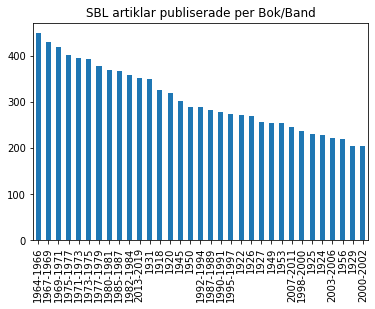

In [180]:
plotSBLYearBand.plot( kind = 'bar') 
plt.title("SBL artiklar publiserade per Bok/Band")
plt.show()

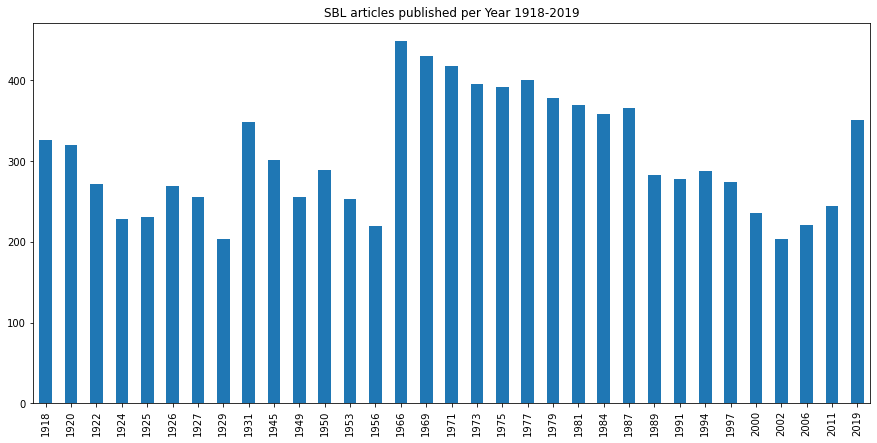

In [299]:
import matplotlib.dates as mdates  
dfSBLcsv.set_index('YearPublished',inplace=True)  
dfSBLcsv["YearPublished"] = dfSBLcsv["Year"].str[-4:] 
dfSBLcsv["YearPublished"] = dfSBLcsv["YearPublished"].astype("datetime64")
dfSBLcsv["YearPublished"].dt.strftime('%Y')
# set date as index
fig, ax = plt.subplots(figsize=(15,7))
years_fmt = mdates.DateFormatter('%M')
ax.xaxis.set_major_formatter(years_fmt) 

#plotSBLYearPublished = dfSBLcsv["YearPublished"].dt.year.value_counts().sort_index()
plotSBLYearPublished = dfSBLcsv["YearPublished"].dt.strftime("%Y").value_counts().sort_index()
plotSBLYearPublished.plot( kind = 'bar',ax=ax)   

#set major ticks format
#ax.xaxis_date()
#ax.autoscale_view()
#ax.xaxis.set_major_formatter(mdates.DateFormatter('%b %d'))
plt.title("SBL articles published per Year 1918-2019")
plt.savefig('SBL_published_articles_1918-2018.png')  
plt.show()  
#plotSBLYearPublished.info

In [182]:
dfSBLcsv.info()a

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10127 entries, 1918-01-01 to 1924-01-01
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          10127 non-null  int64         
 1   SBLlength      10127 non-null  int64         
 2   titel          10127 non-null  object        
 3   Fodd           7081 non-null   object        
 4   Dod            7563 non-null   object        
 5   Band           10127 non-null  object        
 6   Year           10111 non-null  object        
 7   url            10127 non-null  object        
 8   YearPublished  10111 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 791.2+ KB


In [183]:
dfSBLcsv.head()

,SBLnr,SBLlength,titel,Fodd,Dod,Band,Year,url,YearPublished
YearPublished,,,,,,,,,
1918-01-01,5490,12160,"Abelin, släkt",NaN,NaN,"Band 01 (1918), sida 1.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...,1918-01-01
1918-01-01,5491,36851,Gustaf R Abelin,Född:1819-05-17 – Linköpings Domkyrkoförsamlin...,"Död:1903-09-19 – Kvillinge församling, Östergö...","Band 01 (1918), sida 5.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...,1918-01-01
1918-01-01,5492,46079,Hjalmar A Abelin,Född:1817-05-22 – Linköpings Domkyrkoförsamlin...,"Död:1893-09-13 – Stockholms stad, Stockholms län","Band 01 (1918), sida 1.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...,1918-01-01
1918-01-01,5493,23231,C Rudolf Z Abelin,"Född:1864-05-30 – Malmö stad, Skåne län","Död:1961 – Västra Karups församling, Kristians...","Band 01 (1918), sida 9.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...,1918-01-01
1918-01-01,5494,28942,P Wilhelm Abenius,"Född:1864-05-21 – Orsa församling, Dalarnas län","Död:1956 – Ramsbergs församling, Örebro län","Band 01 (1918), sida 11.",1918,https://sok.riksarkivet.se/sbl/Presentation.as...,1918-01-01


In [184]:
dfSBLcsv["url"] = "https://sok.riksarkivet.se/sbl/Presentation.aspx?id=" + str(dfSBLcsv["SBLnr"])

In [185]:
#dfFamily = dfSBLAuthorcsv.dropna()  
dfPerson = dfSBLcsv.dropna(subset = ['Fodd', 'Dod'])

In [186]:
dfPerson.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 7074 entries, 1918-01-01 to 2019-01-01
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          7074 non-null   int64         
 1   SBLlength      7074 non-null   int64         
 2   titel          7074 non-null   object        
 3   Fodd           7074 non-null   object        
 4   Dod            7074 non-null   object        
 5   Band           7074 non-null   object        
 6   Year           7073 non-null   object        
 7   url            7074 non-null   object        
 8   YearPublished  7073 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 552.7+ KB


### Join Wikidata
as Wikidata we guess knows what articles are about a man and a women we can try merge 

In [283]:
dfSBLcsv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10127 entries, 1918-01-01 to 1924-01-01
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          10127 non-null  int64         
 1   SBLlength      10127 non-null  int64         
 2   titel          10127 non-null  object        
 3   Fodd           7081 non-null   object        
 4   Dod            7563 non-null   object        
 5   Band           10127 non-null  object        
 6   Year           10111 non-null  object        
 7   url            10127 non-null  object        
 8   YearPublished  10111 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 791.2+ KB


In [287]:
dfSBLcsv.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 10127 entries, 1918-01-01 to 1924-01-01
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          10127 non-null  int64         
 1   SBLlength      10127 non-null  int64         
 2   titel          10127 non-null  object        
 3   Fodd           7081 non-null   object        
 4   Dod            7563 non-null   object        
 5   Band           10127 non-null  object        
 6   Year           10111 non-null  object        
 7   url            10127 non-null  object        
 8   YearPublished  10111 non-null  datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 791.2+ KB


In [286]:
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7599 non-null   object
 1   SBLnr        7599 non-null   int64 
 2   gender       7599 non-null   object
 3   genderLabel  7599 non-null   object
dtypes: int64(1), object(3)
memory usage: 237.6+ KB


In [289]:
WDSBLtot.head()

,wid,SBLnr,gender,genderLabel
0,Q15405,14482,http://www.wikidata.org/entity/Q6581097,man
1,Q154460,11768,http://www.wikidata.org/entity/Q6581097,man
2,Q320977,11661,http://www.wikidata.org/entity/Q6581097,man
3,Q322335,9430,http://www.wikidata.org/entity/Q6581097,man
4,Q343674,7317,http://www.wikidata.org/entity/Q6581097,man


In [290]:
WDSBLtot["genderLabel"].value_counts()  

man         7071
kvinna       527
transman       1
Name: genderLabel, dtype: int64

In [288]:
#WDSBLtot plotSBLYearPublished  
mergeWDSBLwebscrape = pd.merge(WDSBLtot, dfSBLcsv,how='outer',left_on='SBLnr', right_on='SBLnr',indicator=True)   
mergeWDSBLwebscrape.rename(columns={"_merge": "WD_Webscrape"},inplace = True)
mergeWDSBLwebscrape['WD_Webscrape'] = mergeWDSBLwebscrape['WD_Webscrape'].str.replace('left_only','WD_only').str.replace('right_only','scrape_only')
mergeWDSBLwebscrape["WD_Webscrape"].value_counts()  


both           7599
scrape_only    2531
Name: WD_Webscrape, dtype: int64

In [304]:
dfWD_SBL_article = mergeWDSBLwebscrape[mergeWDSBLwebscrape.WD_Webscrape.str.contains("both")]
#dfWDSKBLarticle.YearPublished.dt.strftime("%Y") 
#dfWDSKBLarticle.info()  
dfWD_SBL_female_article = dfWD_SBL_article[dfWD_SBL_article.genderLabel.str.contains("kvinna")]
dfWD_SBL_female_article.head()  
# Year genderLabel count

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,Year,url,YearPublished,WD_Webscrape
15,Q2576159,12455,http://www.wikidata.org/entity/Q6581072,kvinna,27433,"A F Wilhelmina Hallwyl, von",Född:1844-10-01 – Tyska Sankta Gertruds försam...,Död:1930-07-25 – Tyska Sankta Gertruds församl...,"Band 18 (1969-1971), sida 68.",1969-1971,https://sok.riksarkivet.se/sbl/Presentation.as...,1971-01-01,both
17,Q3355468,7869,http://www.wikidata.org/entity/Q6581072,kvinna,52985,Elise Ottesen-Jensen,"Född:1886-01-02 – Norge (i Højland, Rogaland)",Död:1973-09-04 – Kungsholm eller Ulrika Eleono...,"Band 28 (1992-1994), sida 450.",1992-1994,https://sok.riksarkivet.se/sbl/Presentation.as...,1994-01-01,both
21,Q4975387,6846,http://www.wikidata.org/entity/Q6581072,kvinna,84865,Mathilda L Roos,Född:1852-08-02 – Stockholms domkyrkoförsamlin...,"Död:1908-07-17 – Danderyds församling, Stockho...","Band 30 (1998-2000), sida 339.",1998-2000,https://sok.riksarkivet.se/sbl/Presentation.as...,2000-01-01,both
106,Q444475,11967,http://www.wikidata.org/entity/Q6581072,kvinna,21697,Ingrid Elofsdotter,NaN,"Död:1282-09-02 – Skänninge stad, Östergötlands...","Band 20 (1973-1975), sida 25.",1973-1975,https://sok.riksarkivet.se/sbl/Presentation.as...,1975-01-01,both
116,Q2482366,11769,http://www.wikidata.org/entity/Q6581072,kvinna,17658,Kristina,NaN,Död:levde 1158,"Band 21 (1975-1977), sida 570.",1975-1977,https://sok.riksarkivet.se/sbl/Presentation.as...,1977-01-01,both


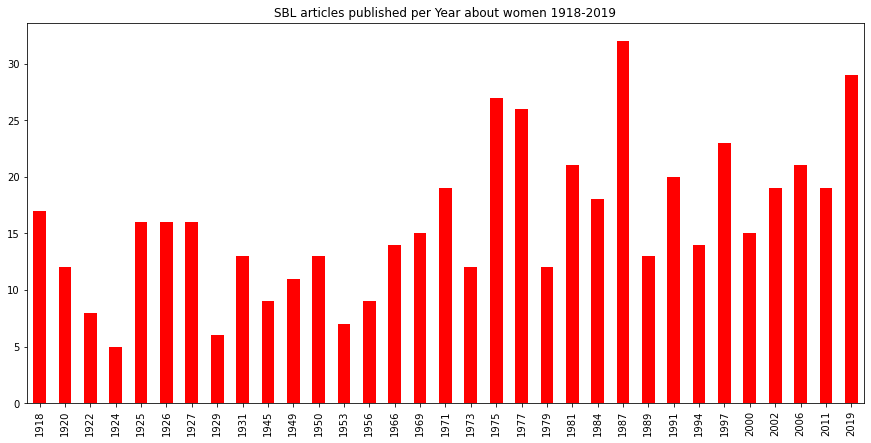

In [361]:
# set date as index
fig = plt.subplots(figsize=(15,7))

plotSBLYearFemailPublished = dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index().plot(kind='bar', color=['red'])

plt.title("SBL articles published per Year about women 1918-2019")
plt.savefig('SBL_published_articles_women_1918-2018.png')  
plt.show()  
#plotSBLYearPublished.info 


In [365]:
dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index(ascending=False)

2019    29
2011    19
2006    21
2002    19
2000    15
1997    23
1994    14
1991    20
1989    13
1987    32
1984    18
1981    21
1979    12
1977    26
1975    27
1973    12
1971    19
1969    15
1966    14
1956     9
1953     7
1950    13
1949    11
1945     9
1931    13
1929     6
1927    16
1926    16
1925    16
1924     5
1922     8
1920    12
1918    17
Name: YearPublished, dtype: int64

In [356]:
dfWD_SBL_female_article.head()

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,Year,url,YearPublished,WD_Webscrape
15,Q2576159,12455,http://www.wikidata.org/entity/Q6581072,kvinna,27433,"A F Wilhelmina Hallwyl, von",Född:1844-10-01 – Tyska Sankta Gertruds försam...,Död:1930-07-25 – Tyska Sankta Gertruds församl...,"Band 18 (1969-1971), sida 68.",1969-1971,https://sok.riksarkivet.se/sbl/Presentation.as...,1971-01-01,both
17,Q3355468,7869,http://www.wikidata.org/entity/Q6581072,kvinna,52985,Elise Ottesen-Jensen,"Född:1886-01-02 – Norge (i Højland, Rogaland)",Död:1973-09-04 – Kungsholm eller Ulrika Eleono...,"Band 28 (1992-1994), sida 450.",1992-1994,https://sok.riksarkivet.se/sbl/Presentation.as...,1994-01-01,both
21,Q4975387,6846,http://www.wikidata.org/entity/Q6581072,kvinna,84865,Mathilda L Roos,Född:1852-08-02 – Stockholms domkyrkoförsamlin...,"Död:1908-07-17 – Danderyds församling, Stockho...","Band 30 (1998-2000), sida 339.",1998-2000,https://sok.riksarkivet.se/sbl/Presentation.as...,2000-01-01,both
106,Q444475,11967,http://www.wikidata.org/entity/Q6581072,kvinna,21697,Ingrid Elofsdotter,NaN,"Död:1282-09-02 – Skänninge stad, Östergötlands...","Band 20 (1973-1975), sida 25.",1973-1975,https://sok.riksarkivet.se/sbl/Presentation.as...,1975-01-01,both
116,Q2482366,11769,http://www.wikidata.org/entity/Q6581072,kvinna,17658,Kristina,NaN,Död:levde 1158,"Band 21 (1975-1977), sida 570.",1975-1977,https://sok.riksarkivet.se/sbl/Presentation.as...,1977-01-01,both


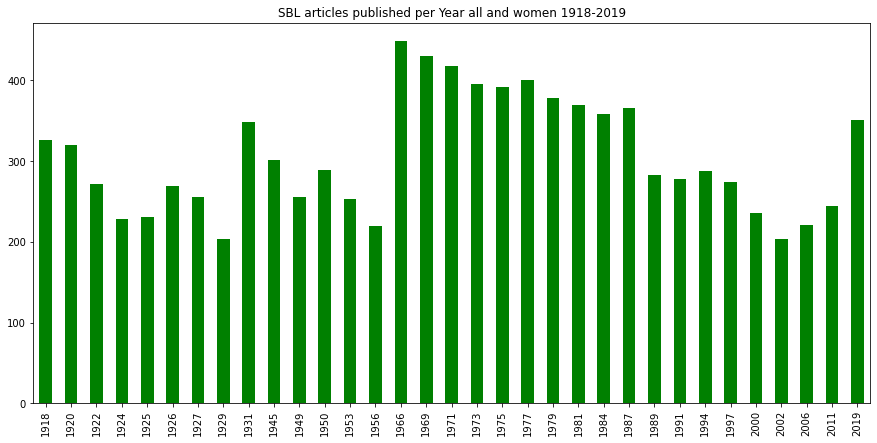

In [350]:
fig = plt.subplots(figsize=(15,7))

plotSBLYearFemailPublished = dfWD_SBL_female_article["YearPublished"].dt.strftime("%Y").value_counts().sort_index().plot(kind='bar', color=['red'])
#plotSBLYearPublished = dfSBLcsv["YearPublished"].dt.strftime("%Y").value_counts().sort_index()
plotSBLYearPublished.plot( kind = 'bar', color=['g']) 
plt.title("SBL articles published per Year all and women 1918-2019")
plt.savefig('SBL_published_articles_all_women_1918-2018.png')  
plt.show()  

In [354]:
speed = [0.1, 17.5, 40, 48, 52, 69, 88]
lifespan = [2, 8, 70, 1.5, 25, 12, 28]
index = ['snail', 'pig', 'elephant',
          'rabbit', 'giraffe', 'coyote', 'horse']
df = pd.DataFrame({'speed': speed,
                    'lifespan': lifespan}, index=index)
#ax = df.plot.bar(rot=0)


#plotSBLYearPublished_FM = dfWD_SBL_article.groupby(["YearPublished"])
#plotSBLYearPublished_FM = dfWD_SBL_article.groupby(["YearPublished"])["genderLabel"].transform("count")
#df['Counts'] = df.groupby(['Color'])['Value'].transform('count')
#plotSBLYearPublished_FM.head()  
dfWD_SBL_article.info()
dfWD_SBL_article.head()

# Group by YearPublished genderLabel

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7599 entries, 0 to 7598
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7599 non-null   object        
 1   SBLnr          7599 non-null   int64         
 2   gender         7599 non-null   object        
 3   genderLabel    7599 non-null   object        
 4   SBLlength      7599 non-null   int64         
 5   titel          7599 non-null   object        
 6   Fodd           7080 non-null   object        
 7   Dod            7558 non-null   object        
 8   Band           7599 non-null   object        
 9   Year           7598 non-null   object        
 10  url            7599 non-null   object        
 11  YearPublished  7598 non-null   datetime64[ns]
 12  WD_Webscrape   7599 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 831.1+ KB


,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,Year,url,YearPublished,WD_Webscrape
0,Q15405,14482,http://www.wikidata.org/entity/Q6581097,man,74999,Elias M Fries,"Född:1794-08-15 – Femsjö församling, Hallands län","Död:1878-02-08 – Uppsala domkyrkoförsamling, U...","Band 16 (1964-1966), sida 522.",1964-1966,https://sok.riksarkivet.se/sbl/Presentation.as...,1966-01-01,both
1,Q154460,11768,http://www.wikidata.org/entity/Q6581097,man,45847,Kristian II,Född:1481-07-02,Död:1559-01-25,"Band 21 (1975-1977), sida 566.",1975-1977,https://sok.riksarkivet.se/sbl/Presentation.as...,1977-01-01,both
2,Q320977,11661,http://www.wikidata.org/entity/Q6581097,man,54804,Knut Eriksson,NaN,Död:1195/96,"Band 21 (1975-1977), sida 383.",1975-1977,https://sok.riksarkivet.se/sbl/Presentation.as...,1977-01-01,both
3,Q322335,9430,http://www.wikidata.org/entity/Q6581097,man,51007,Lars Larsson (Lasse-Maja) Molin,"Född:1785-10-05 – Ramsbergs församling, Örebro...","Död:1845-06-04 – Arboga stadsförsamling, Västm...","Band 25 (1985-1987), sida 648.",1985-1987,https://sok.riksarkivet.se/sbl/Presentation.as...,1987-01-01,both
4,Q343674,7317,http://www.wikidata.org/entity/Q6581097,man,50014,"Baltzar J E Platen, von","Född:1804-04-16 – Näs församling (R-län), Skar...","Död:1875-03-20 – Jakobs församling, Stockholms...","Band 29 (1995-1997), sida 359.",1995-1997,https://sok.riksarkivet.se/sbl/Presentation.as...,1997-01-01,both


### Släktartiklar  
Nedan lite gissning att en släktartikel har ordet släkt i titeln. 

* se också [webscarping Adelsvapen](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6)
* csv lista skapad nedan på [GIST](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6#gistcomment-3457126) 

In [187]:
dfFamily = dfSBLcsv[dfSBLcsv.isnull().any(1)]

In [188]:
dfFamily.info()

<class 'pandas.core.frame.DataFrame'>
DatetimeIndex: 3054 entries, 1918-01-01 to 1924-01-01
Data columns (total 9 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   SBLnr          3054 non-null   int64         
 1   SBLlength      3054 non-null   int64         
 2   titel          3054 non-null   object        
 3   Fodd           8 non-null      object        
 4   Dod            490 non-null    object        
 5   Band           3054 non-null   object        
 6   Year           3038 non-null   object        
 7   url            3054 non-null   object        
 8   YearPublished  3038 non-null   datetime64[ns]
dtypes: datetime64[ns](1), int64(2), object(6)
memory usage: 238.6+ KB


In [189]:
#dfFamily

In [190]:
dfFamilySlakt = dfFamily[dfFamily.titel.str.contains("släkt")]
#dfFamilySlakt

In [191]:
dictFamily = dfFamilySlakt.to_dict()

In [192]:
dfFamily.titel.str.contains("släkt").sum()

1722

In [193]:
dfFamily.titel.str.contains("ätten").sum()

37

In [194]:
dfFamily.titel.str.contains("Släkt").sum()

1

In [195]:
dfFamily.Dod.str.contains("senas").sum()

22

In [196]:
#dfFamily[dfFamily.Dod.str.contains("senas", na=False)]

In [353]:
dfFamily[dfFamily.Fodd.str.contains("", na=False)].head

<bound method NDFrame.head of                SBLnr  ...  YearPublished
YearPublished         ...               
1918-01-01      5671  ...     1918-01-01
1918-01-01      5735  ...     1918-01-01
2006-01-01      6061  ...     2006-01-01
1931-01-01     15777  ...     1931-01-01
1931-01-01     15784  ...     1931-01-01
1931-01-01     15785  ...     1931-01-01
1926-01-01     16990  ...     1926-01-01
NaT            34648  ...            NaT

[8 rows x 9 columns]>

In [198]:
#Check diff WDSBLtot and dfSBLcsv 
WDSBLtot.duplicated(subset=['wid']).sum()

0

In [199]:
dfSBLcsv.duplicated(subset=['SBLnr']).sum()

0

In [200]:
WDSBLtot.duplicated(subset=['sblid']).sum()

3

In [201]:
WDSBLtot = WDSBLtot.rename(columns={'sblid':'SBLnr'})
WDSBLtot['SBLnr']= WDSBLtot['SBLnr'].astype(str).astype(int)
WDSBLtot.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 7599 entries, 0 to 7598
Data columns (total 4 columns):
 #   Column       Non-Null Count  Dtype 
---  ------       --------------  ----- 
 0   wid          7599 non-null   object
 1   SBLnr        7599 non-null   int64 
 2   gender       7599 non-null   object
 3   genderLabel  7599 non-null   object
dtypes: int64(1), object(3)
memory usage: 237.6+ KB


In [202]:
dfmerge = pd.merge(WDSBLtot, dfSBLcsv,how='outer', on='SBLnr',indicator=True)

In [203]:
dfmerge["_merge"].value_counts()

both          7599
right_only    2531
left_only        0
Name: _merge, dtype: int64

In [204]:
#dfmerge

In [205]:
dfmerge['_merge'] = dfmerge['_merge'].str.replace('left_only','WD_only').str.replace('right_only','SBL_only')


In [206]:
WDSBLonly = dfmerge[dfmerge["_merge"] == "SBL_only"].copy()   
dfmerge["_merge"].value_counts()

both        7599
SBL_only    2531
Name: _merge, dtype: int64

In [207]:
WD_only = dfmerge[dfmerge["_merge"] == "WD_only"].copy()   
WD_only

,wid,SBLnr,gender,genderLabel,SBLlength,titel,Fodd,Dod,Band,Year,url,YearPublished,_merge


In [208]:
WDSBLonly.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 2531 entries, 7599 to 10129
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          2531 non-null   int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      2531 non-null   int64         
 5   titel          2531 non-null   object        
 6   Fodd           3 non-null      object        
 7   Dod            8 non-null      object        
 8   Band           2531 non-null   object        
 9   Year           2516 non-null   object        
 10  url            2531 non-null   object        
 11  YearPublished  2516 non-null   datetime64[ns]
 12  _merge         2531 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 276.8+ KB


In [209]:
WDSBLonly.titel.str.contains("släkt").sum() 


1685

In [352]:
WDSBLonly[WDSBLonly.titel.str.contains("ätt")].head

<bound method NDFrame.head of        wid  SBLnr  ... YearPublished    _merge
7777   NaN   7249  ...    1997-01-01  SBL_only
7948   NaN   9007  ...    1987-01-01  SBL_only
7949   NaN   9008  ...    1987-01-01  SBL_only
7950   NaN   9009  ...    1987-01-01  SBL_only
8238   NaN  11237  ...    1979-01-01  SBL_only
8239   NaN  11238  ...    1979-01-01  SBL_only
8240   NaN  11239  ...    1979-01-01  SBL_only
8255   NaN  11376  ...    1979-01-01  SBL_only
8256   NaN  11377  ...    1979-01-01  SBL_only
8257   NaN  11378  ...    1979-01-01  SBL_only
8258   NaN  11379  ...    1979-01-01  SBL_only
8259   NaN  11380  ...    1979-01-01  SBL_only
8455   NaN  12565  ...    1971-01-01  SBL_only
8456   NaN  12566  ...    1971-01-01  SBL_only
8457   NaN  12568  ...    1971-01-01  SBL_only
8553   NaN  13016  ...    1969-01-01  SBL_only
8572   NaN  13096  ...    1969-01-01  SBL_only
8594   NaN  13177  ...    1969-01-01  SBL_only
8706   NaN  13783  ...    1973-01-01  SBL_only
8776   NaN  14142  ...    1966

In [211]:
#Inte släkt 
WDmissingPerson = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")]

In [212]:
WDmissingPerson.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 846 entries, 7601 to 10129
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          846 non-null    int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      846 non-null    int64         
 5   titel          846 non-null    object        
 6   Fodd           3 non-null      object        
 7   Dod            8 non-null      object        
 8   Band           846 non-null    object        
 9   Year           831 non-null    object        
 10  url            846 non-null    object        
 11  YearPublished  831 non-null    datetime64[ns]
 12  _merge         846 non-null    object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 92.5+ KB


In [213]:
WDmissingPerson["Year"].value_counts()

2013-2019    140
2007-2011     65
1953          53
1985-1987     44
2003-2006     36
1931          33
1950          33
1992-1994     31
1977-1979     29
1982-1984     26
1980-1981     25
1998-2000     25
1973-1975     24
1964-1966     23
1945          21
1987-1989     21
1929          20
1969-1971     20
2000-2002     20
1956          20
1967-1969     20
1949          16
1990-1991     11
1971-1973     11
1920          10
1975-1977     10
1926           9
1995-1997      8
1918           7
1925           7
1927           5
1924           4
1922           4
Name: Year, dtype: int64

In [214]:
print("Min, Max SBLlength: ", WDmissingPerson.SBLlength.min(), WDmissingPerson.SBLlength.max())

Min, Max SBLlength:  11021 82050


In [215]:
# sorterar artiklarna efter sidstorlek för att kanske hitta någon vi missat  
# wid är Wikidata objekt , NaN är att det saknas  
# SBLnr är id i SBL
# SBLlength är sidans storlek hos SBL 
# Fodd, Dod... är det jag hittade i WEBsidan, NaN innebär saknas

#WDmissingPerson.sort_values(by='SBLlength', ascending=False, na_position='first')

In [216]:
WDmissingPerson["Year"].value_counts()

2013-2019    140
2007-2011     65
1953          53
1985-1987     44
2003-2006     36
1931          33
1950          33
1992-1994     31
1977-1979     29
1982-1984     26
1980-1981     25
1998-2000     25
1973-1975     24
1964-1966     23
1945          21
1987-1989     21
1929          20
1969-1971     20
2000-2002     20
1956          20
1967-1969     20
1949          16
1990-1991     11
1971-1973     11
1920          10
1975-1977     10
1926           9
1995-1997      8
1918           7
1925           7
1927           5
1924           4
1922           4
Name: Year, dtype: int64

In [217]:
print("End run: ", datetime.now())

End run:  2020-09-20 23:07:57.781977


In [218]:
#Släkt 
#WDSlakt = WDSBLonly[~WDSBLonly.titel.str.contains("släkt")].copy

In [219]:
WDSlakt = WDSBLonly[WDSBLonly.titel.str.contains("släkt")]

In [220]:
WDSlakt.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 1685 entries, 7599 to 10087
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            0 non-null      object        
 1   SBLnr          1685 non-null   int64         
 2   gender         0 non-null      object        
 3   genderLabel    0 non-null      object        
 4   SBLlength      1685 non-null   int64         
 5   titel          1685 non-null   object        
 6   Fodd           0 non-null      object        
 7   Dod            0 non-null      object        
 8   Band           1685 non-null   object        
 9   Year           1685 non-null   object        
 10  url            1685 non-null   object        
 11  YearPublished  1685 non-null   datetime64[ns]
 12  _merge         1685 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 184.3+ KB


In [351]:
#Need a workaround as pandas to_csv dont work ?!?!?
for  index,row in WDSlakt.iterrows():
#    print(row["SBLnr"],row["titel"],row["Year"],row["url"])    
#    print(row["SBLnr"],"|",row["titel"],"|",row["Year"])  

SyntaxError: unexpected EOF while parsing (<ipython-input-351-e33fe5db66b3>, line 4)

List produced also on [GIST](https://gist.github.com/salgo60/31e0c4bf6f075c373fb5bbfb6cc807c6#gistcomment-3457126) 

### Estimate published articles male/female /family


In [222]:
dfmerge.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 10130 entries, 0 to 10129
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7599 non-null   object        
 1   SBLnr          10130 non-null  int64         
 2   gender         7599 non-null   object        
 3   genderLabel    7599 non-null   object        
 4   SBLlength      10130 non-null  int64         
 5   titel          10130 non-null  object        
 6   Fodd           7083 non-null   object        
 7   Dod            7566 non-null   object        
 8   Band           10130 non-null  object        
 9   Year           10114 non-null  object        
 10  url            10130 non-null  object        
 11  YearPublished  10114 non-null  datetime64[ns]
 12  _merge         10130 non-null  object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 1.1+ MB


In [236]:
personSBL = dfmerge[~dfmerge['wid'].isnull()] 

In [237]:
personSBL.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 7599 entries, 0 to 7598
Data columns (total 13 columns):
 #   Column         Non-Null Count  Dtype         
---  ------         --------------  -----         
 0   wid            7599 non-null   object        
 1   SBLnr          7599 non-null   int64         
 2   gender         7599 non-null   object        
 3   genderLabel    7599 non-null   object        
 4   SBLlength      7599 non-null   int64         
 5   titel          7599 non-null   object        
 6   Fodd           7080 non-null   object        
 7   Dod            7558 non-null   object        
 8   Band           7599 non-null   object        
 9   Year           7598 non-null   object        
 10  url            7599 non-null   object        
 11  YearPublished  7598 non-null   datetime64[ns]
 12  _merge         7599 non-null   object        
dtypes: datetime64[ns](1), int64(2), object(10)
memory usage: 831.1+ KB


In [268]:
plotSBLGender = personSBL.groupby(["genderLabel", "YearPublished"]).size()
plotSBLGender  

genderLabel  YearPublished
kvinna       1918-01-01        17
             1920-01-01        12
             1922-01-01         8
             1924-01-01         5
             1925-01-01        16
             1926-01-01        16
             1927-01-01        16
             1929-01-01         6
             1931-01-01        13
             1945-01-01         9
             1949-01-01        11
             1950-01-01        13
             1953-01-01         7
             1956-01-01         9
             1966-01-01        14
             1969-01-01        15
             1971-01-01        19
             1973-01-01        12
             1975-01-01        27
             1977-01-01        26
             1979-01-01        12
             1981-01-01        21
             1984-01-01        18
             1987-01-01        32
             1989-01-01        13
             1991-01-01        20
             1994-01-01        14
             1997-01-01        23
             2000-01-

In [269]:
plotSBLGender.unstack()

YearPublished,1918-01-01,1920-01-01,1922-01-01,1924-01-01,1925-01-01,1926-01-01,1927-01-01,1929-01-01,1931-01-01,1945-01-01,1949-01-01,1950-01-01,1953-01-01,1956-01-01,1966-01-01,1969-01-01,1971-01-01,1973-01-01,1975-01-01,1977-01-01,1979-01-01,1981-01-01,1984-01-01,1987-01-01,1989-01-01,1991-01-01,1994-01-01,1997-01-01,2000-01-01,2002-01-01,2006-01-01,2011-01-01,2019-01-01
genderLabel,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,,
kvinna,17.0,12.0,8.0,5.0,16.0,16.0,16.0,6.0,13.0,9.0,11.0,13.0,7.0,9.0,14.0,15.0,19.0,12.0,27.0,26.0,12.0,21.0,18.0,32.0,13.0,20.0,14.0,23.0,15.0,19.0,21.0,19.0,29.0
man,255.0,243.0,214.0,188.0,180.0,188.0,181.0,138.0,252.0,203.0,162.0,172.0,148.0,126.0,311.0,285.0,278.0,287.0,284.0,272.0,264.0,283.0,269.0,238.0,229.0,203.0,213.0,222.0,180.0,150.0,141.0,146.0,165.0
transman,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1.0
